# Options Pricing Simulator using Black-Scholes

This notebook simulates European options pricing and Greeks using the Black-Scholes model.  
It includes visualizations for:
- Option pricing vs underlying variables
- 3D surfaces
- Greeks (Delta, Gamma, Vega)
- Profit & Loss (P&L) curves for basic strategies (long call/put, straration.


In [34]:
# importing necessary libraries

import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

## Black Scholes Formula

Call Option :   C = S.N(d1) - K.e^(-rT).N(d2)

Put Option :    P = K.e^(-rT).N(-d2) - S.N(-d1)


where:
      S = spot price of the asset ;
      K = Strike price ;
      r = Risk-free rate ;
      T = Time to maturity ;
      𝜎 = Volatility ;
      N(.) = Standard normal CDF ;

      d1 = ( ln(S/K) + (r + (𝜎^2)/2 )T ) / (𝜎 * sqrt(T))
      d2 = d1 - 𝜎*sqrt(T)

In [9]:
# defining the Black Scholes formula on python
def black_scholes_price(S, K, T, r, sigma, option_type="call"):
    """Calculate Black-Scholes option price for European call/put."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == "call":
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == "put":
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("option_type must be 'call' or 'put'")
    
    return price


In [11]:
# Sample run of the formula:

S = 100      # Current stock price
K = 100      # Strike price
T = 1        # 1 year to expiry
r = 0.05     # 5% risk-free rate
sigma = 0.2  # 20% volatility

call_price = black_scholes_price(S, K, T, r, sigma, option_type="call")
put_price = black_scholes_price(S, K, T, r, sigma, option_type="put")

print(f"Call Price: {call_price:.2f}")
print(f"Put Price: {put_price:.2f}")


Call Price: 10.45
Put Price: 5.57


### Plotting Option Price v/s Underlying Price

Fixing all other parameters and varying S (spot price) to see how the option value changes.

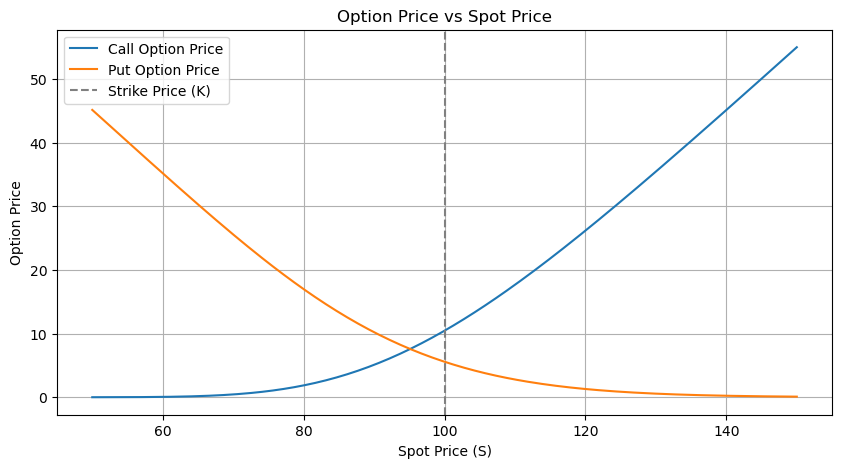

In [14]:
S_values = np.linspace(50, 150, 200)  # Varying stock price from 50 to 150

call_prices = [black_scholes_price(S, K, T, r, sigma, option_type="call") for S in S_values]
put_prices = [black_scholes_price(S, K, T, r, sigma, option_type="put") for S in S_values]

plt.figure(figsize=(10, 5))
plt.plot(S_values, call_prices, label="Call Option Price")
plt.plot(S_values, put_prices, label="Put Option Price")
plt.axvline(K, color='gray', linestyle='--', label="Strike Price (K)")
plt.xlabel("Spot Price (S)")
plt.ylabel("Option Price")
plt.title("Option Price vs Spot Price")
plt.legend()
plt.grid(True)
plt.show()


### Interpretation:

* Calls increase with spot price
* Puts decrease with spot price
* Kink arounf the strike price (K = 100)

## Introducing the Greeks

### Delta (Sensitivity to stock price)

Measures how much the option price changes with a small change in S.

     Delta = N(d1)      ; for call options
     Delta = N(d1) - 1  ; for put options

### Gamma (Sensitivity of Delta to Stock Price)

Measure convexity, i.e. how Delta changes.

      Gamma = ( N'(d1) ) / (S𝜎*sqrt(T))

### Vega (Sensitivity to Volatitlity)

Measures how price changes with volatility.

      Vega = S . N'(d1) . sqrt(T)

In [19]:
# Coding these greeks on python:

def black_scholes_greeks(S, K, T, r, sigma, option_type="call"):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    delta = norm.cdf(d1) if option_type == "call" else norm.cdf(d1) - 1
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    vega = S * norm.pdf(d1) * np.sqrt(T)

    return delta, gamma, vega


## Plotting the Greeks v/s Spot Price

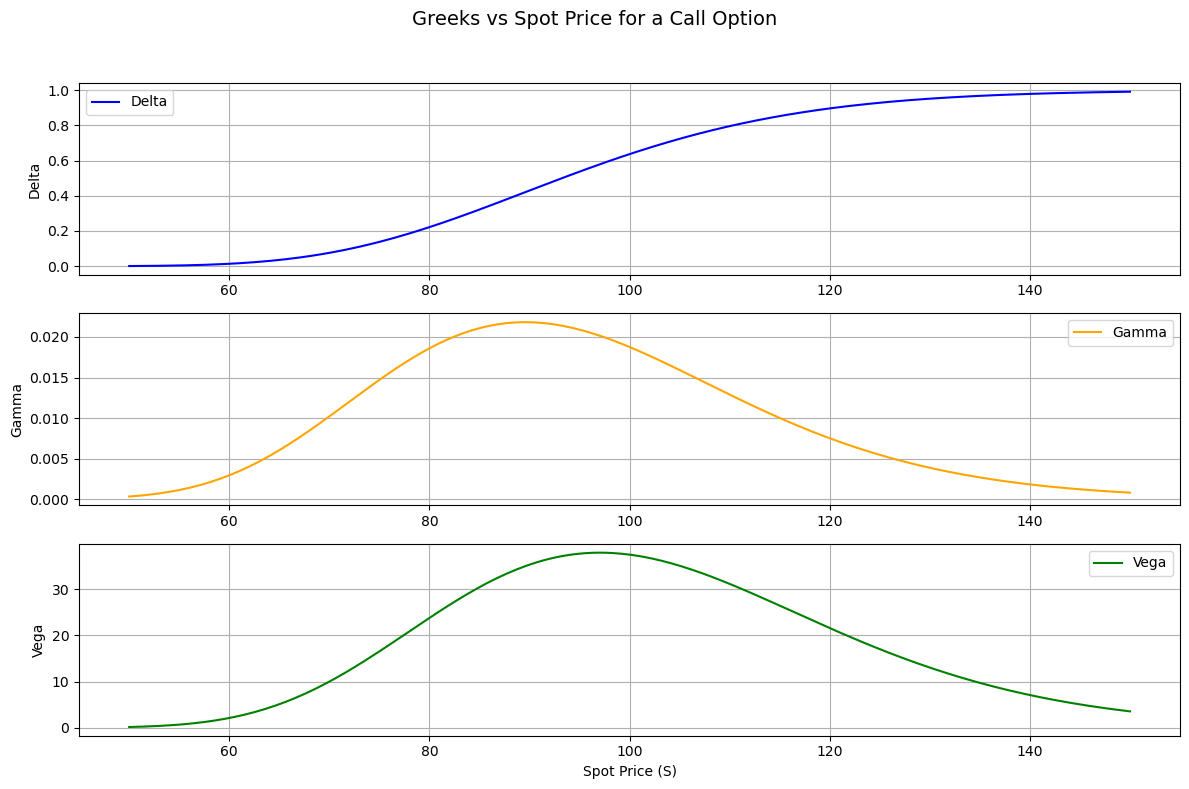

In [22]:
deltas, gammas, vegas = [], [], []

for S in S_values:
    delta, gamma, vega = black_scholes_greeks(S, K, T, r, sigma, option_type="call")
    deltas.append(delta)
    gammas.append(gamma)
    vegas.append(vega)

plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(S_values, deltas, label="Delta", color="blue")
plt.ylabel("Delta")
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(S_values, gammas, label="Gamma", color="orange")
plt.ylabel("Gamma")
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(S_values, vegas, label="Vega", color="green")
plt.xlabel("Spot Price (S)")
plt.ylabel("Vega")
plt.grid(True)
plt.legend()

plt.suptitle("Greeks vs Spot Price for a Call Option", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Call Option Price v/s Spot and Volatility

In [36]:
S_range = np.linspace(50, 150, 50)
sigma_range = np.linspace(0.05, 0.6, 50)
S_grid, sigma_grid = np.meshgrid(S_range, sigma_range)

K = 100
T = 1
r = 0.05

Z = np.zeros_like(S_grid)

# Calculate call prices over the grid
for i in range(S_grid.shape[0]):
    for j in range(S_grid.shape[1]):
        Z[i, j] = black_scholes_price(S_grid[i, j], K, T, r, sigma_grid[i, j], option_type="call")


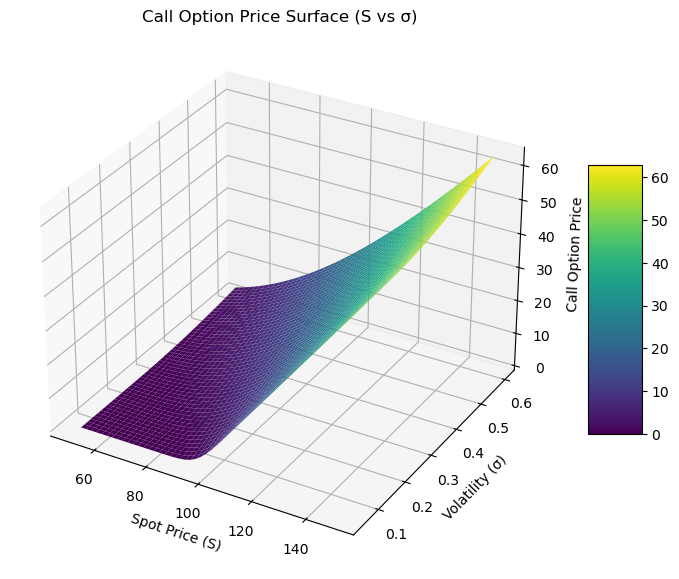

In [38]:
# Plotting these on a 3-D surface

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(S_grid, sigma_grid, Z, cmap=cm.viridis, edgecolor='none')
ax.set_xlabel('Spot Price (S)')
ax.set_ylabel('Volatility (σ)')
ax.set_zlabel('Call Option Price')
ax.set_title('Call Option Price Surface (S vs σ)')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()


# Simulating Profit and Loss (P&L) Curves 

## Long Call Option:

* Strike price K = 100
* Premium paid = price of the option (from Black-Scholes)
* (P&L) = max{(S_T - K), 0} - Premuim

In [41]:
# P&L plotted at expiry with a sample inputs
def plot_pnl_long_call(S_range, K, premium):
    payoff = np.maximum(S_range - K, 0)
    pnl = payoff - premium

    plt.figure(figsize=(8, 5))
    plt.plot(S_range, pnl, label="P&L", color='blue')
    plt.axhline(0, color='black', linestyle='--')
    plt.axvline(K, color='gray', linestyle='--', label="Strike Price")
    plt.title("P&L for Long Call Option at Expiry")
    plt.xlabel("Stock Price at Expiry (S_T)")
    plt.ylabel("Profit / Loss")
    plt.grid(True)
    plt.legend()
    plt.show()


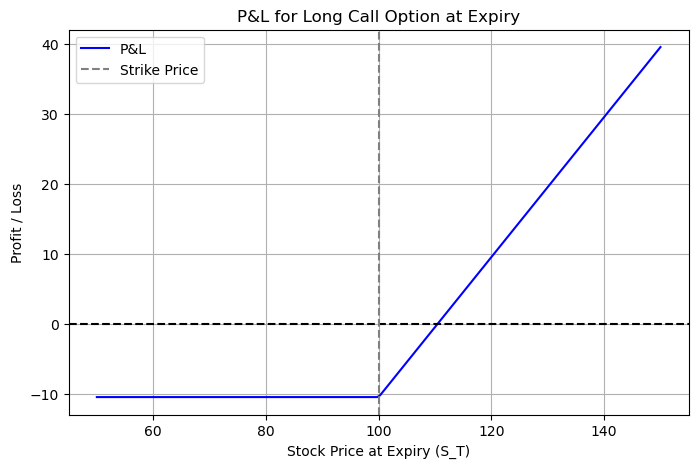

In [43]:
K = 100
T = 1
r = 0.05
sigma = 0.2
S_range = np.linspace(50, 150, 200)

# Get option premium using BS model
premium = black_scholes_price(100, K, T, r, sigma, option_type="call")
plot_pnl_long_call(S_range, K, premium)


## Long Put P&L at Expiry

(P&L) = max{(K - S_T), 0} - Premium

In [48]:
# Plotting long Put P&L at Expiry with sample inputs

def plot_pnl_long_put(S_range, K, premium):
    payoff = np.maximum(K - S_range, 0)
    pnl = payoff - premium

    plt.figure(figsize=(8, 5))
    plt.plot(S_range, pnl, label="P&L", color='purple')
    plt.axhline(0, color='black', linestyle='--')
    plt.axvline(K, color='gray', linestyle='--', label="Strike Price")
    plt.title("P&L for Long Put Option at Expiry")
    plt.xlabel("Stock Price at Expiry (S_T)")
    plt.ylabel("Profit / Loss")
    plt.grid(True)
    plt.legend()
    plt.show()


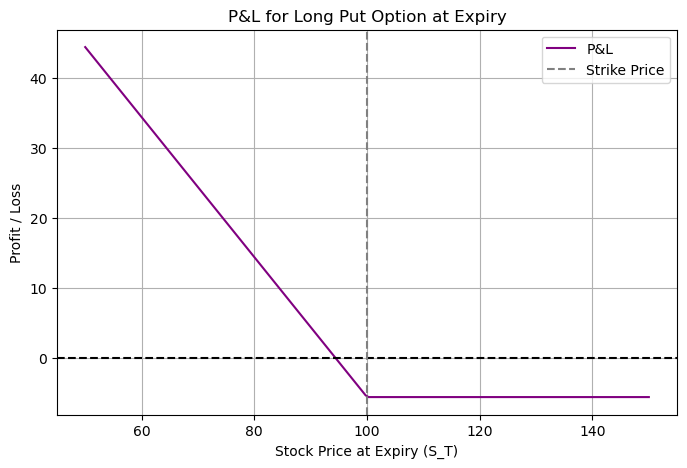

In [50]:
# Using same K, T, r, sigma
premium_put = black_scholes_price(100, K, T, r, sigma, option_type="put")
plot_pnl_long_put(S_range, K, premium_put)


## Long Straddle - P&L at Expiry

* Buy 1 Call and Buy 1 Put at the same Strike Price (K)
* We profit if the stock moves a lot in either direction, which is a great strategy fir volatility trading.


     (P&L) = max{(S_T - K), 0} + max{(K - S_T), 0} - (Call Premium) - (Put Premium)

In [54]:
def plot_pnl_straddle(S_range, K, premium_call, premium_put):
    payoff_call = np.maximum(S_range - K, 0)
    payoff_put = np.maximum(K - S_range, 0)
    pnl = payoff_call + payoff_put - premium_call - premium_put

    plt.figure(figsize=(8, 5))
    plt.plot(S_range, pnl, label="Straddle P&L", color='darkgreen')
    plt.axhline(0, color='black', linestyle='--')
    plt.axvline(K, color='gray', linestyle='--', label="Strike Price")
    plt.title("P&L for Long Straddle at Expiry")
    plt.xlabel("Stock Price at Expiry (S_T)")
    plt.ylabel("Profit / Loss")
    plt.grid(True)
    plt.legend()
    plt.show()


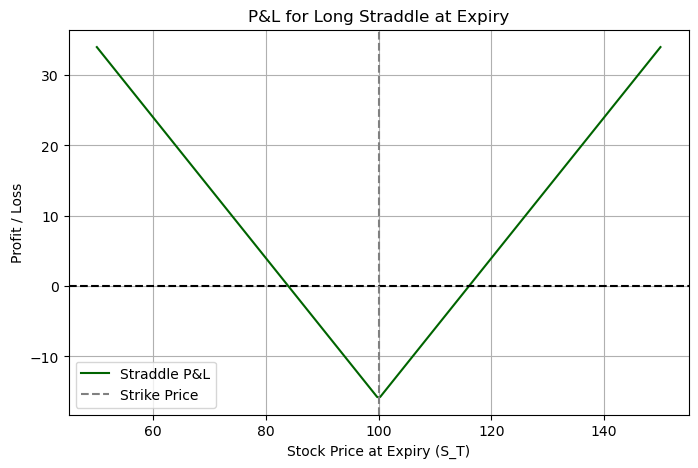

In [56]:
# Reuse S_range, K, T, r, sigma
premium_call = black_scholes_price(K, K, T, r, sigma, option_type="call")
premium_put = black_scholes_price(K, K, T, r, sigma, option_type="put")

plot_pnl_straddle(S_range, K, premium_call, premium_put)
